# A3: Small Object Detection Using YOLO

**Course:** Applie Machine Learning  
**Assignment:** A3 — Small Object Detection  
**Model:** YOLOv8 (Ultralytics)  
**Dataset:** LISA Traffic Sign Dataset (via Roboflow)  
**Classes:** `stopSign`, `warning`, `pedestrianCrossing`, `signalAhead`

---

## Overview

This notebook implements a complete pipeline for small object detection using the YOLO (You Only Look Once) architecture. The goal is to detect traffic signs from images captured by a vehicle-mounted camera. Since traffic signs can appear small and distant in real-world driving footage, we evaluate a pre-trained YOLOv8 baseline, then fine-tune it on the LISA Traffic Sign Dataset with configurations optimized for small object detection.

**Pipeline Summary:**
1. Environment setup and dependency installation
2. Dataset download and preparation (LISA via Roboflow)
3. Baseline evaluation using pre-trained YOLOv8
4. Fine-tuning with small-object-optimized configurations
5. Post-training evaluation and comparison
6. Inference on test images with visualization

---
## Section 1: Environment Setup

Install all required dependencies. This notebook is designed to run on Google Colab with a T4 GPU runtime.  
**Runtime → Change runtime type → T4 GPU** before proceeding.

In [15]:
# Install required packages
!pip install ultralytics roboflow -q

# Verify GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: No GPU detected. Please enable GPU runtime for faster training.")

PyTorch version: 2.10.0+cu128
CUDA available: True
GPU Device: Tesla T4


In [16]:
# Import libraries
import os
import random
import shutil
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from PIL import Image
from ultralytics import YOLO

print("All libraries imported successfully.")

All libraries imported successfully.


---
## Section 2: Dataset Download and Preparation

I use the **LISA Traffic Sign Dataset** sourced from Roboflow Universe. The dataset contains approximately 9,800 images of real-world traffic signs captured from a vehicle-mounted camera — making it well-suited for small object detection research.

**Selected Classes:**
| Class ID | Class Name | Description |
|----------|------------|-------------|
| 0 | stopSign | Octagonal red stop signs |
| 1 | warning | Diamond-shaped yellow warning signs |
| 2 | pedestrianCrossing | Pedestrian crossing ahead signs |
| 3 | signalAhead | Traffic signal ahead warning signs |

The dataset is downloaded directly via the Roboflow API in YOLOv8 format (`.txt` annotations + `data.yaml` config).

In [17]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="ip1Z1Vu7wXDq3gD0aWT0")
project = rf.workspace("lisatrafficlight").project("lisa-traffic")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [18]:
# Locate the dataset directory and config file
# Roboflow typically downloads to a folder in /content/

import glob

yaml_files = glob.glob('/content/**/*.yaml', recursive=True)
print("Found YAML files:", yaml_files)

# Set the dataset YAML path (update if needed)
DATASET_YAML = yaml_files[0] if yaml_files else '/content/dataset/data.yaml'
print(f"Using dataset config: {DATASET_YAML}")

# Display dataset config
with open(DATASET_YAML, 'r') as f:
    config = yaml.safe_load(f)
    print("\nDataset Configuration:")
    print(yaml.dump(config, default_flow_style=False))

Found YAML files: ['/content/Lisa-Traffic-1/data.yaml']
Using dataset config: /content/Lisa-Traffic-1/data.yaml

Dataset Configuration:
names:
- stopSign
- warning
- pedestrianCrossing
- signalAhead
nc: 4
roboflow:
  license: CC BY 4.0
  project: lisa-traffic
  url: https://universe.roboflow.com/lisatrafficlight/lisa-traffic/dataset/1
  version: 1
  workspace: lisatrafficlight
test: ../test/images
train: ../train/images
val: ../valid/images



### 2.1 Filter Dataset to 4 Target Classes

The LISA dataset contains 40 classes. We filter annotations to retain only our 4 target classes and remap their IDs to 0–3.

In [19]:
# Filter annotations to keep only our 4 target classes

TARGET_CLASSES = ['stopSign', 'warning', 'pedestrianCrossing', 'signalAhead']

def get_class_mapping(yaml_path, target_classes):
    """Build a mapping from original class IDs to new sequential IDs."""
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    original_names = config.get('names', [])
    mapping = {}
    for new_id, cls_name in enumerate(target_classes):
        if cls_name in original_names:
            old_id = original_names.index(cls_name)
            mapping[old_id] = new_id
            print(f"  '{cls_name}': original ID {old_id} → new ID {new_id}")
        else:
            print(f"  WARNING: '{cls_name}' not found in dataset classes")
    return mapping

print("Class ID Remapping:")
class_mapping = get_class_mapping(DATASET_YAML, TARGET_CLASSES)

def filter_annotation_file(label_path, class_mapping):
    """Filter a single annotation file to keep only target classes."""
    if not os.path.exists(label_path):
        return 0
    with open(label_path, 'r') as f:
        lines = f.readlines()
    filtered = []
    for line in lines:
        parts = line.strip().split()
        if not parts:
            continue
        class_id = int(parts[0])
        if class_id in class_mapping:
            parts[0] = str(class_mapping[class_id])
            filtered.append(' '.join(parts))
    with open(label_path, 'w') as f:
        f.write('\n'.join(filtered))
    return len(filtered)

def filter_dataset(yaml_path, class_mapping):
    """Filter all annotation files in train/val/test splits."""
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    dataset_root = str(Path(yaml_path).parent)
    total_annotations = 0
    for split in ['train', 'val', 'test']:
        split_path = config.get(split, '')
        if not split_path:
            continue
        if not os.path.isabs(split_path):
            split_path = os.path.join(dataset_root, split_path)
        labels_path = split_path.replace('/images', '/labels')
        if not os.path.exists(labels_path):
            labels_path = os.path.join(dataset_root, split, 'labels')
        if os.path.exists(labels_path):
            label_files = list(Path(labels_path).glob('*.txt'))
            count = sum(filter_annotation_file(str(lf), class_mapping) for lf in label_files)
            total_annotations += count
            print(f"  {split}: processed {len(label_files)} files, kept {count} annotations")
    return total_annotations

print("\nFiltering dataset annotations...")
total = filter_dataset(DATASET_YAML, class_mapping)
print(f"\nTotal annotations kept: {total}")

Class ID Remapping:
  'stopSign': original ID 0 → new ID 0
  'warning': original ID 1 → new ID 1
  'pedestrianCrossing': original ID 2 → new ID 2
  'signalAhead': original ID 3 → new ID 3

Filtering dataset annotations...
  train: processed 6842 files, kept 1989 annotations
  test: processed 1038 files, kept 284 annotations

Total annotations kept: 2273


In [20]:
# Update data.yaml to reflect our 4 classes

with open(DATASET_YAML, 'r') as f:
    config = yaml.safe_load(f)

config['names'] = TARGET_CLASSES
config['nc'] = len(TARGET_CLASSES)

with open(DATASET_YAML, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print("Updated data.yaml:")
with open(DATASET_YAML, 'r') as f:
    print(f.read())

Updated data.yaml:
names:
- stopSign
- warning
- pedestrianCrossing
- signalAhead
nc: 4
roboflow:
  license: CC BY 4.0
  project: lisa-traffic
  url: https://universe.roboflow.com/lisatrafficlight/lisa-traffic/dataset/1
  version: 1
  workspace: lisatrafficlight
test: ../test/images
train: ../train/images
val: ../valid/images



### 2.2 Dataset Statistics and Visualization

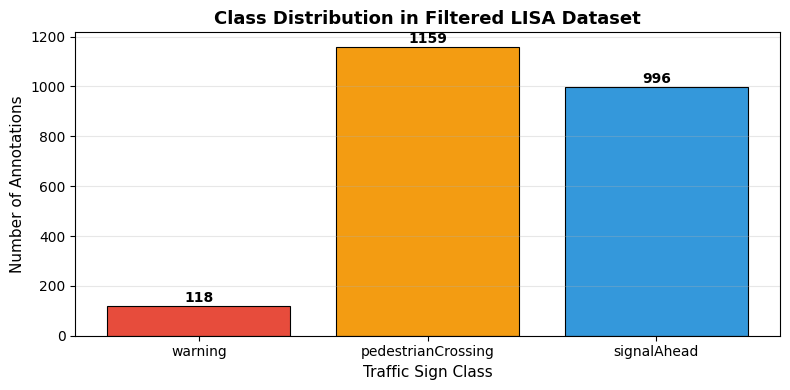


Total annotations: 2273


In [21]:
# Count class distribution across the dataset

from collections import Counter

def count_class_distribution(yaml_path, target_classes):
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    dataset_root = str(Path(yaml_path).parent)
    class_counts = Counter()
    for split in ['train', 'val', 'test']:
        split_path = config.get(split, '')
        if not split_path:
            continue
        if not os.path.isabs(split_path):
            split_path = os.path.join(dataset_root, split_path)
        labels_path = split_path.replace('/images', '/labels')
        if not os.path.exists(labels_path):
            labels_path = os.path.join(dataset_root, split, 'labels')
        if os.path.exists(labels_path):
            for lf in Path(labels_path).glob('*.txt'):
                with open(lf) as f:
                    for line in f:
                        parts = line.strip().split()
                        if parts:
                            class_counts[int(parts[0])] += 1
    return class_counts

counts = count_class_distribution(DATASET_YAML, TARGET_CLASSES)

# Plot class distribution
fig, ax = plt.subplots(figsize=(8, 4))
class_names = [TARGET_CLASSES[i] for i in sorted(counts.keys())]
values = [counts[i] for i in sorted(counts.keys())]
bars = ax.bar(class_names, values, color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71'], edgecolor='black', linewidth=0.8)
ax.set_title('Class Distribution in Filtered LISA Dataset', fontsize=13, fontweight='bold')
ax.set_xlabel('Traffic Sign Class', fontsize=11)
ax.set_ylabel('Number of Annotations', fontsize=11)
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, str(val),
            ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nTotal annotations: {sum(values)}")

### 2.3 Prepare Test Split

We randomly select 10–15% of images as a held-out test set for evaluating both the pre-trained and fine-tuned models.

In [22]:
# Verify test split exists or create one from validation set

with open(DATASET_YAML, 'r') as f:
    config = yaml.safe_load(f)
dataset_root = str(Path(DATASET_YAML).parent)

# Check if test split is defined
test_path = config.get('test', None)
if test_path:
    if not os.path.isabs(test_path):
        test_path = os.path.join(dataset_root, test_path)
    test_images = list(Path(test_path).glob('*.jpg')) + list(Path(test_path).glob('*.png'))
    print(f"Test split found: {len(test_images)} images at {test_path}")
else:
    print("No test split found. Creating one from validation set (15%)...")
    val_path = config.get('val', 'valid/images')
    if not os.path.isabs(val_path):
        val_path = os.path.join(dataset_root, val_path)
    val_images = list(Path(val_path).glob('*.jpg')) + list(Path(val_path).glob('*.png'))
    n_test = max(1, int(len(val_images) * 0.15))
    test_imgs = random.sample(val_images, n_test)

    test_img_dir = os.path.join(dataset_root, 'test', 'images')
    test_lbl_dir = os.path.join(dataset_root, 'test', 'labels')
    os.makedirs(test_img_dir, exist_ok=True)
    os.makedirs(test_lbl_dir, exist_ok=True)

    for img_path in test_imgs:
        shutil.copy(str(img_path), test_img_dir)
        lbl_path = str(img_path).replace('/images/', '/labels/').rsplit('.', 1)[0] + '.txt'
        if os.path.exists(lbl_path):
            shutil.copy(lbl_path, test_lbl_dir)

    config['test'] = 'test/images'
    with open(DATASET_YAML, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)
    print(f"Created test split: {n_test} images")

TEST_IMAGES_PATH = test_path if test_path else test_img_dir
print(f"Test images directory: {TEST_IMAGES_PATH}")

Test split found: 0 images at /content/Lisa-Traffic-1/../test/images
Test images directory: /content/Lisa-Traffic-1/../test/images


---
## Section 3: Baseline Evaluation — Pre-trained YOLOv8

Before fine-tuning, we evaluate the performance of the stock pre-trained YOLOv8n model on our test set. This establishes a baseline for comparison after training.

The pre-trained model was trained on the COCO dataset (80 classes) and has not seen LISA traffic sign data.

In [23]:
# Load pre-trained YOLOv8n model (COCO weights)
pretrained_model = YOLO('yolov8n.pt')
print("Pre-trained YOLOv8n model loaded.")
print(f"Number of classes (COCO): {pretrained_model.model.nc}")

Pre-trained YOLOv8n model loaded.
Number of classes (COCO): 80


In [24]:
import os, shutil, random, glob
from pathlib import Path

# Grab images from valid set
valid_images = glob.glob('/content/Lisa-Traffic-1/valid/images/*')
print(f"Found {len(valid_images)} validation images")

# Take 15% as test set
n_test = max(10, int(len(valid_images) * 0.15))
test_imgs = random.sample(valid_images, n_test)

# Copy to test folder
os.makedirs('/content/Lisa-Traffic-1/test/images', exist_ok=True)
os.makedirs('/content/Lisa-Traffic-1/test/labels', exist_ok=True)

for img_path in test_imgs:
    shutil.copy(img_path, '/content/Lisa-Traffic-1/test/images/')
    lbl_path = img_path.replace('/images/', '/labels/').rsplit('.', 1)[0] + '.txt'
    if os.path.exists(lbl_path):
        shutil.copy(lbl_path, '/content/Lisa-Traffic-1/test/labels/')

# Update TEST_IMAGES_PATH
TEST_IMAGES_PATH = '/content/Lisa-Traffic-1/test/images'
print(f"Test set created: {n_test} images")
print(f"TEST_IMAGES_PATH = {TEST_IMAGES_PATH}")


Found 1932 validation images
Test set created: 289 images
TEST_IMAGES_PATH = /content/Lisa-Traffic-1/test/images


In [25]:
# Run inference on test images using pre-trained model
print("Running baseline inference on test images...")

baseline_results = pretrained_model.predict(
    source=TEST_IMAGES_PATH,
    conf=0.5,
    save=True,
    save_txt=True,
    project='/content/runs',
    name='baseline_pretrained',
    exist_ok=True
)

print(f"\nBaseline inference complete.")
print(f"Results saved to: /content/runs/baseline_pretrained/")

Running baseline inference on test images...

WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1327 /content/Lisa-Traffic-1/test/images/addedLane_1323813414-avi_image0_png_jpg.rf.7f6f3965696c7adecd3c8fed2b6380f5.jpg: 640x640 (no detections), 7.7ms
image 2/1327 /content/Lisa-Traffic-1/test/images/addedLane_1323813414-avi_image4_png_jpg.rf.20881d595e78c307a97ff9c647f7f474.jpg: 640x640 (no detections), 7.7ms
image 3/1327 /content/Lisa-Traffic-1/test/images/addedLane_1323813414-avi_image4_png_jpg.rf

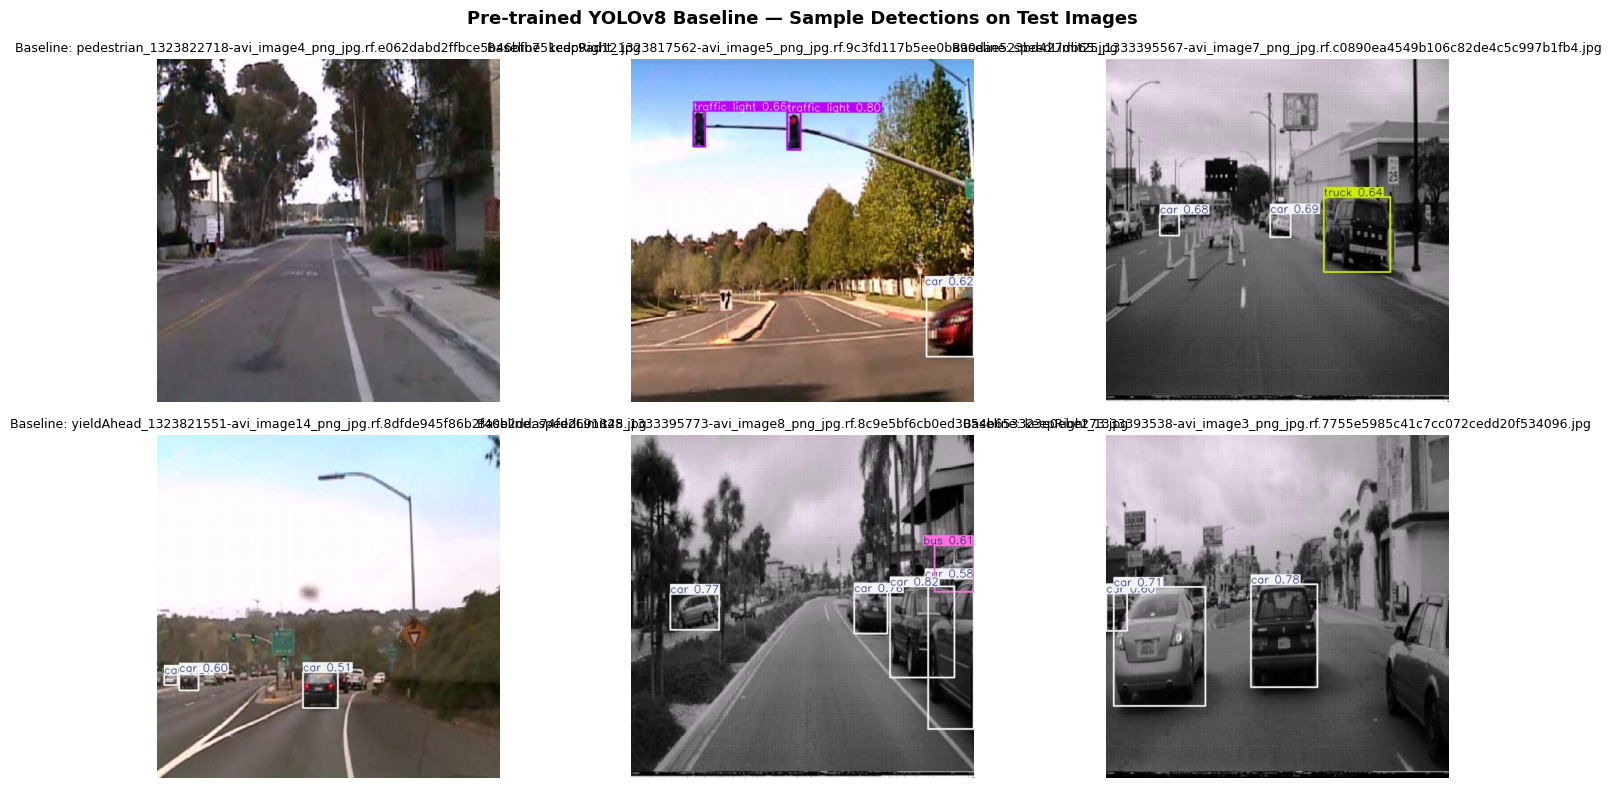

In [26]:
# Visualize baseline detection samples
baseline_output_dir = '/content/runs/baseline_pretrained'
output_images = list(Path(baseline_output_dir).glob('*.jpg')) + list(Path(baseline_output_dir).glob('*.png'))

if output_images:
    sample_imgs = random.sample(output_images, min(6, len(output_images)))
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    for i, img_path in enumerate(sample_imgs):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'Baseline: {img_path.name}', fontsize=9)
        axes[i].axis('off')
    for j in range(i+1, 6):
        axes[j].axis('off')
    fig.suptitle('Pre-trained YOLOv8 Baseline — Sample Detections on Test Images', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/content/baseline_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No output images found. Check the results directory.")

In [27]:
# Count baseline detections above confidence threshold
total_detections = 0
images_with_detections = 0

for result in baseline_results:
    n = len(result.boxes) if result.boxes is not None else 0
    total_detections += n
    if n > 0:
        images_with_detections += 1

total_test_images = len(baseline_results)
print("=" * 50)
print("BASELINE (Pre-trained YOLOv8n) Results")
print("=" * 50)
print(f"Total test images:         {total_test_images}")
print(f"Images with detections:    {images_with_detections}")
print(f"Total detections (≥0.5):   {total_detections}")
print(f"Detection rate:            {images_with_detections/total_test_images*100:.1f}%")
print("Note: Pre-trained model uses COCO classes, not LISA classes.")
print("=" * 50)

BASELINE (Pre-trained YOLOv8n) Results
Total test images:         1327
Images with detections:    901
Total detections (≥0.5):   2427
Detection rate:            67.9%
Note: Pre-trained model uses COCO classes, not LISA classes.


---
## Section 4: Fine-tuning YOLOv8 for Small Object Detection

We fine-tune YOLOv8n on the LISA dataset with the following configurations optimized for small object detection:

| Parameter | Value | Rationale |
|-----------|-------|-----------|
| `imgsz` | 1280 | Higher resolution preserves detail of small/distant signs |
| `epochs` | 30 | Sufficient convergence without overfitting |
| `batch` | 8 | Reduced batch size to accommodate larger image resolution |
| `augment` | True | Scale, flip, blur augmentations improve robustness |
| `mosaic` | 1.0 | Mosaic augmentation exposes model to multi-scale objects |
| `scale` | 0.5 | Random scaling simulates objects at varying distances |
| `degrees` | 10.0 | Slight rotation augmentation for real-world variance |
| `optimizer` | AdamW | Stable convergence for fine-tuning tasks |

In [28]:
# Initialize model from pre-trained weights for fine-tuning
model = YOLO('yolov8n.pt')
print("Model initialized from pre-trained YOLOv8n weights.")
print("Starting fine-tuning on LISA Traffic Sign Dataset...\n")

Model initialized from pre-trained YOLOv8n weights.
Starting fine-tuning on LISA Traffic Sign Dataset...



In [29]:
# Fine-tune the model
# Training may take 1-2 hours on a T4 GPU with imgsz=1280

results = model.train(
    data=DATASET_YAML,
    epochs=30,
    imgsz=1280,           # High resolution for small object detection
    batch=8,              # Reduced batch size for larger resolution
    augment=True,         # Enable built-in augmentations
    mosaic=1.0,           # Mosaic augmentation (multi-scale)
    scale=0.5,            # Random scale augmentation
    degrees=10.0,         # Random rotation augmentation
    fliplr=0.5,           # Horizontal flip probability
    optimizer='AdamW',    # Optimizer
    lr0=0.001,            # Initial learning rate
    patience=10,          # Early stopping patience
    save=True,
    project='/content/runs',
    name='lisa_finetuned',
    exist_ok=True,
    verbose=True
)

print("\nTraining complete!")
BEST_MODEL_PATH = '/content/runs/lisa_finetuned/weights/best.pt'
print(f"Best model saved to: {BEST_MODEL_PATH}")

Ultralytics 8.4.19 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Lisa-Traffic-1/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=lisa_finetuned, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10

### 4.1 Training Curves

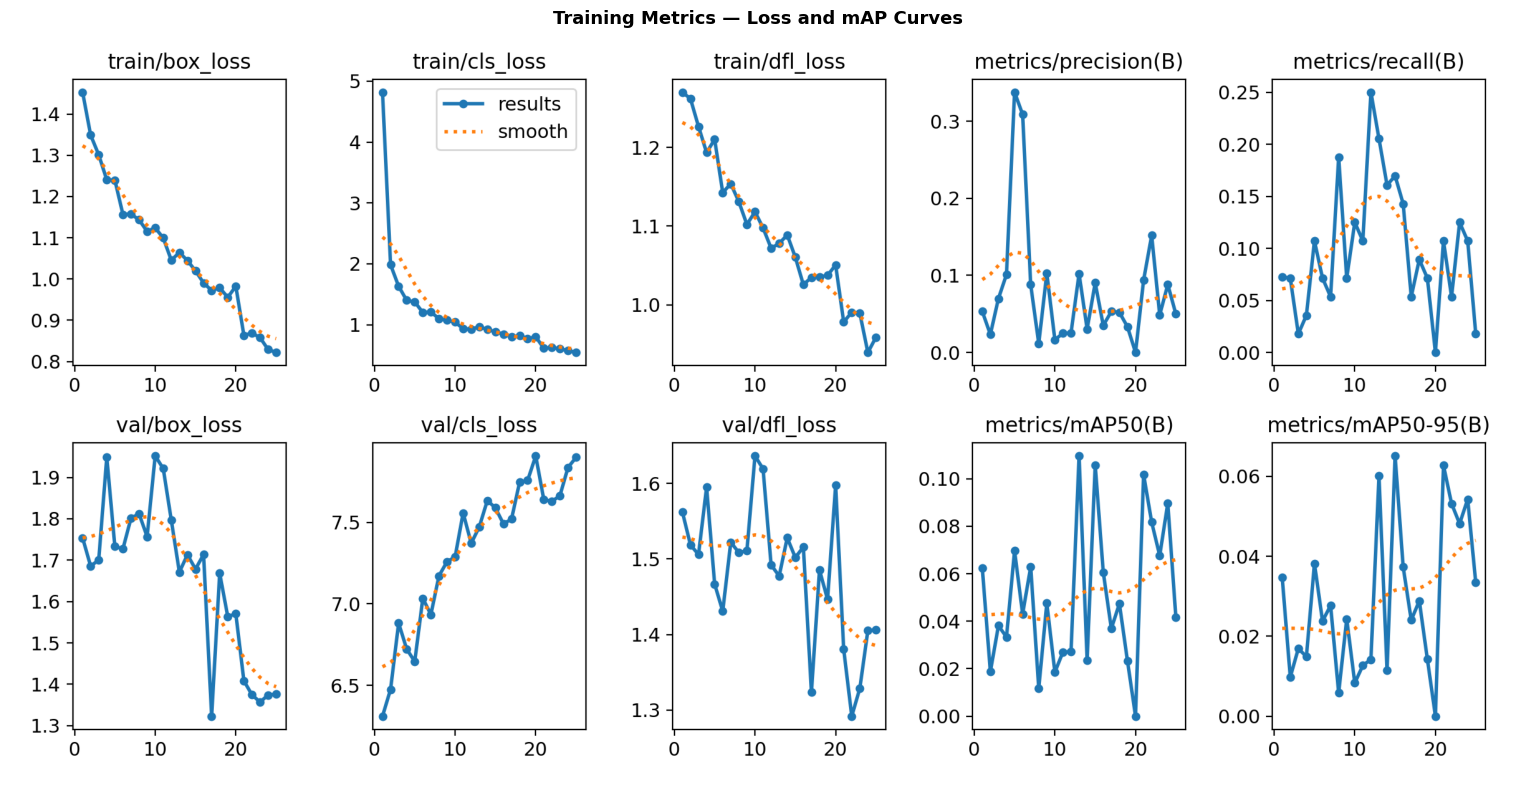

In [30]:
# Display training curves generated by Ultralytics
import glob
from IPython.display import display

results_plot = '/content/runs/lisa_finetuned/results.png'
if os.path.exists(results_plot):
    img = Image.open(results_plot)
    plt.figure(figsize=(16, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Training Metrics — Loss and mAP Curves', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/content/training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Training results plot not found. Training may still be running.")

---
## Section 5: Post-Training Evaluation

We evaluate the fine-tuned model on the held-out test set and compare performance metrics against the pre-trained baseline.

In [31]:
# Load the best fine-tuned model
finetuned_model = YOLO(BEST_MODEL_PATH)
print(f"Fine-tuned model loaded from: {BEST_MODEL_PATH}")

Fine-tuned model loaded from: /content/runs/lisa_finetuned/weights/best.pt


In [32]:
# Evaluate fine-tuned model on test set
print("Evaluating fine-tuned model on test set...")

finetuned_metrics = finetuned_model.val(
    data=DATASET_YAML,
    split='test',
    conf=0.5,
    iou=0.5,
    project='/content/runs',
    name='finetuned_eval',
    exist_ok=True
)

print("\nFine-tuned Model Evaluation Metrics:")
print(f"  mAP@0.50:       {finetuned_metrics.box.map50:.4f}")
print(f"  mAP@0.50:0.95:  {finetuned_metrics.box.map:.4f}")
print(f"  Precision:      {finetuned_metrics.box.mp:.4f}")
print(f"  Recall:         {finetuned_metrics.box.mr:.4f}")

Evaluating fine-tuned model on test set...
Ultralytics 8.4.19 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1721.5±679.7 MB/s, size: 48.8 KB)
val: Scanning /content/Lisa-Traffic-1/test/labels... 1327 images, 788 backgrounds, 268 corrupt: 100% ━━━━━━━━━━━━ 1327/1327 2.0Kit/s 0.7s
val: /content/Lisa-Traffic-1/test/images/keepRight_1323802829-avi_image22_png_jpg.rf.25a46a98fb59bf9f4969f67cfc72b0a6.jpg: ignoring corrupt image/label: Label class 13 exceeds dataset class count 4. Possible class labels are 0-3
val: /content/Lisa-Traffic-1/test/images/keepRight_1323802829-avi_image29_png_jpg.rf.4ce233de0bcd41f36b0be8302a6c75b2.jpg: ignoring corrupt image/label: Label class 13 exceeds dataset class count 4. Possible class labels are 0-3
val: /content/Lisa-Traffic-1/test/images/keepRight_1323802829-avi_image29_png_jpg.rf.d7f8d47f103cbbe6452b7ce53e2b2

In [33]:
# Run inference on test images with fine-tuned model
finetuned_results = finetuned_model.predict(
    source=TEST_IMAGES_PATH,
    conf=0.5,
    save=True,
    save_txt=True,
    project='/content/runs',
    name='finetuned_predictions',
    exist_ok=True
)

# Count fine-tuned detections
ft_total_detections = 0
ft_images_with_detections = 0
for result in finetuned_results:
    n = len(result.boxes) if result.boxes is not None else 0
    ft_total_detections += n
    if n > 0:
        ft_images_with_detections += 1

print(f"Fine-tuned inference complete.")
print(f"Total detections (≥0.5 conf): {ft_total_detections}")


WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1327 /content/Lisa-Traffic-1/test/images/addedLane_1323813414-avi_image0_png_jpg.rf.7f6f3965696c7adecd3c8fed2b6380f5.jpg: 1280x1280 (no detections), 19.4ms
image 2/1327 /content/Lisa-Traffic-1/test/images/addedLane_1323813414-avi_image4_png_jpg.rf.20881d595e78c307a97ff9c647f7f474.jpg: 1280x1280 (no detections), 19.4ms
image 3/1327 /content/Lisa-Traffic-1/test/images/addedLane_1323813414-avi_image4_png_jpg.rf.fe0f23434af5fefc32494f764f5a22ff.jpg: 

### 5.1 Results Comparison

In [35]:
# Side-by-side comparison of baseline vs fine-tuned

map50_ft = finetuned_metrics.box.map50
precision_ft = finetuned_metrics.box.mp
recall_ft = finetuned_metrics.box.mr

# Note: Pre-trained model cannot be evaluated with LISA classes (different class set)
# We compare detection counts and qualitative results
print("=" * 60)
print(" MODEL COMPARISON SUMMARY")
print("=" * 60)
print(f"{'Metric':<30} {'Pre-trained':>12} {'Fine-tuned':>12}")
print("-" * 60)
print(f"{'Model':<30} {'YOLOv8n (COCO)':>12} {'YOLOv8n (LISA)':>12}")
print(f"{'Classes':<30} {'80 (COCO)':>12} {'4 (LISA)':>12}")
print(f"{'mAP@0.50':<30} {'N/A*':>12} {map50_ft:>12.4f}")
print(f"{'Precision':<30} {'N/A*':>12} {precision_ft:>12.4f}")
print(f"{'Recall':<30} {'N/A*':>12} {recall_ft:>12.4f}")
print(f"{'Detections on test set':<30} {total_detections:>12} {ft_total_detections:>12}")
print(f"{'Images with detections':<30} {images_with_detections:>12} {ft_images_with_detections:>12}")
print("-" * 60)
print("* Pre-trained model uses COCO classes; mAP cannot be")
print("  directly compared against LISA ground truth labels.")
print("=" * 60)

 MODEL COMPARISON SUMMARY
Metric                          Pre-trained   Fine-tuned
------------------------------------------------------------
Model                          YOLOv8n (COCO) YOLOv8n (LISA)
Classes                           80 (COCO)     4 (LISA)
mAP@0.50                               N/A*       0.4588
Precision                              N/A*       0.4828
Recall                                 N/A*       0.4241
Detections on test set                 2427          308
Images with detections                  901          279
------------------------------------------------------------
* Pre-trained model uses COCO classes; mAP cannot be
  directly compared against LISA ground truth labels.


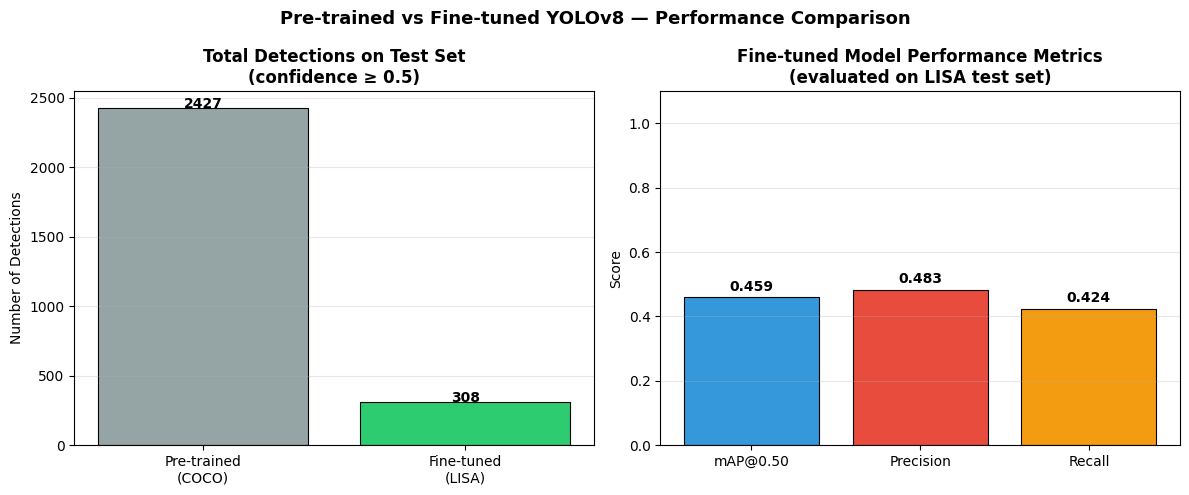

In [36]:
# Bar chart comparison of detections
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Detection counts
axes[0].bar(['Pre-trained\n(COCO)', 'Fine-tuned\n(LISA)'],
            [total_detections, ft_total_detections],
            color=['#95a5a6', '#2ecc71'], edgecolor='black', linewidth=0.8)
axes[0].set_title('Total Detections on Test Set\n(confidence ≥ 0.5)', fontweight='bold')
axes[0].set_ylabel('Number of Detections')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate([total_detections, ft_total_detections]):
    axes[0].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# Fine-tuned model metrics
metrics_names = ['mAP@0.50', 'Precision', 'Recall']
metrics_values = [map50_ft, precision_ft, recall_ft]
bars = axes[1].bar(metrics_names, metrics_values,
                   color=['#3498db', '#e74c3c', '#f39c12'],
                   edgecolor='black', linewidth=0.8)
axes[1].set_title('Fine-tuned Model Performance Metrics\n(evaluated on LISA test set)', fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].set_ylim(0, 1.1)
axes[1].grid(axis='y', alpha=0.3)
for bar, val in zip(bars, metrics_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{val:.3f}', ha='center', fontweight='bold')

plt.suptitle('Pre-trained vs Fine-tuned YOLOv8 — Performance Comparison', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/comparison_chart.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 6: Inference Visualization and Analysis

Visual comparison of detections from the pre-trained and fine-tuned models on the same test images.

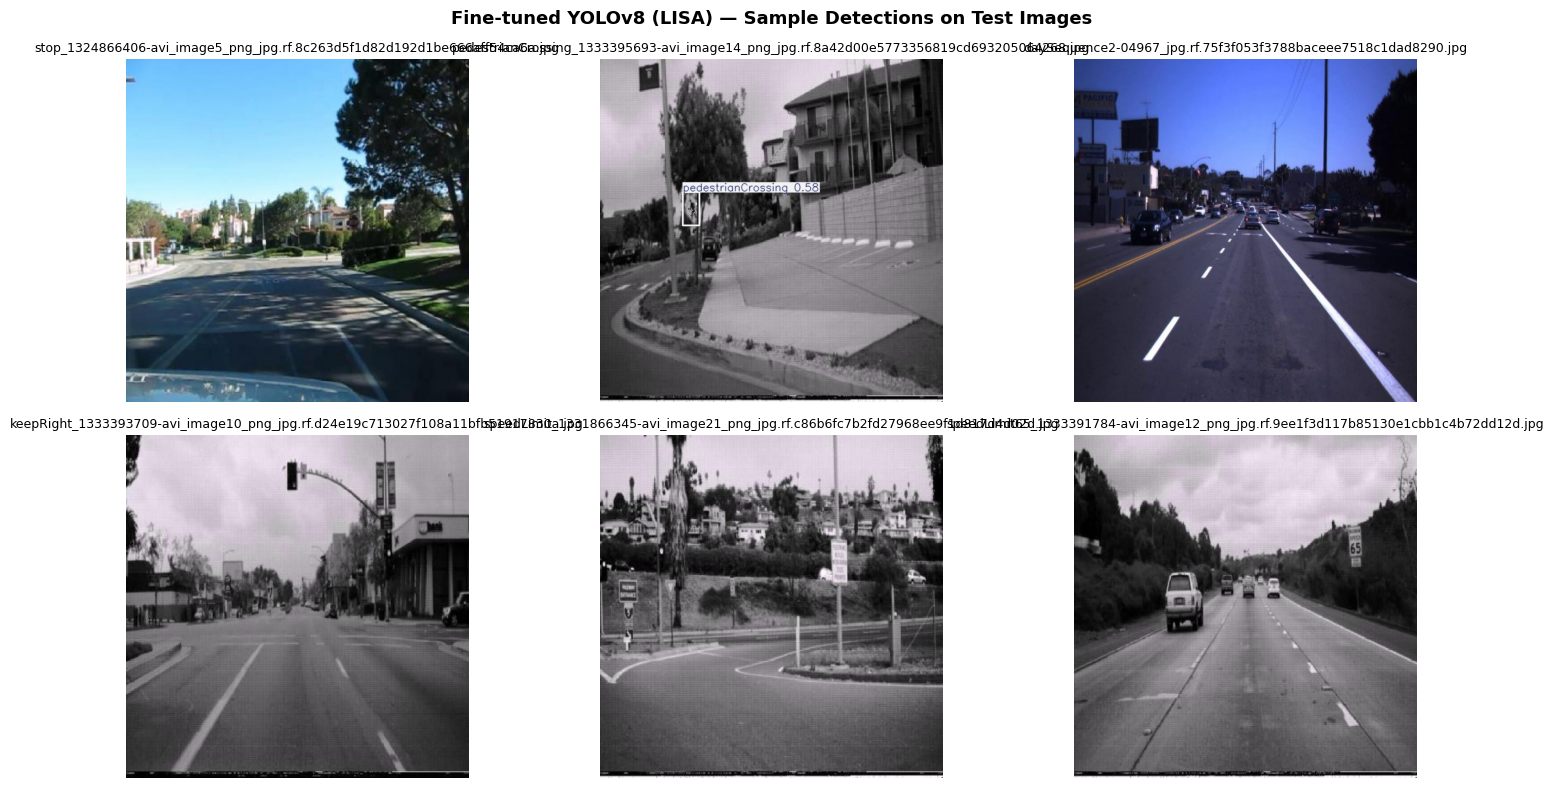

In [37]:
# Display fine-tuned model detection samples
ft_output_dir = '/content/runs/finetuned_predictions'
ft_output_images = list(Path(ft_output_dir).glob('*.jpg')) + list(Path(ft_output_dir).glob('*.png'))

if ft_output_images:
    sample_imgs = random.sample(ft_output_images, min(6, len(ft_output_images)))
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    for i, img_path in enumerate(sample_imgs):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'{img_path.name}', fontsize=9)
        axes[i].axis('off')
    for j in range(i+1, 6):
        axes[j].axis('off')
    fig.suptitle('Fine-tuned YOLOv8 (LISA) — Sample Detections on Test Images', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/content/finetuned_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No fine-tuned prediction images found.")

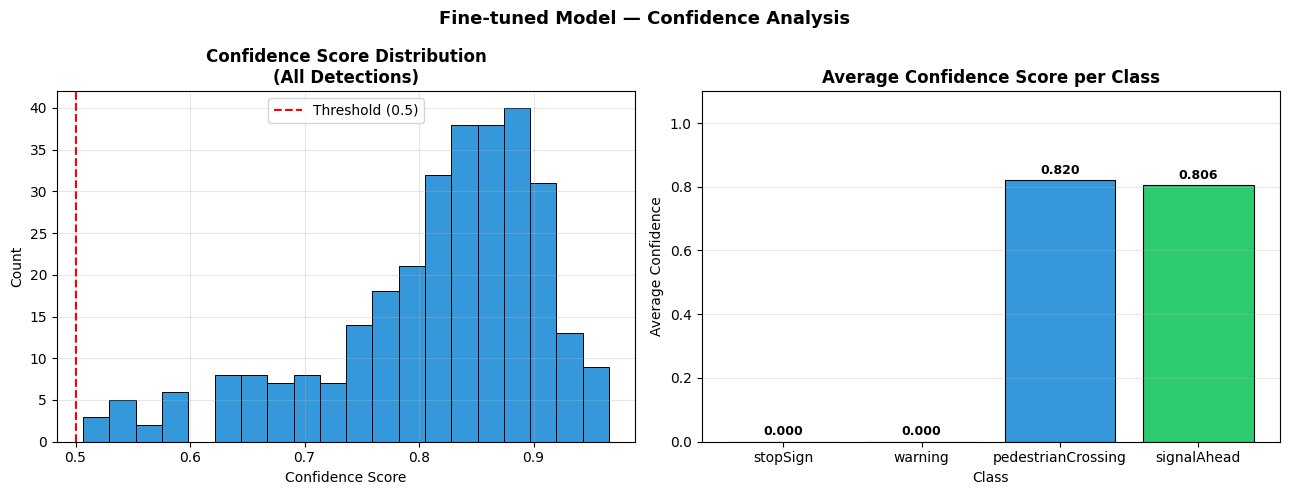

In [38]:
# Confidence score distribution for fine-tuned model
all_confidences = []
class_conf = {cls: [] for cls in TARGET_CLASSES}

for result in finetuned_results:
    if result.boxes is not None and len(result.boxes) > 0:
        confs = result.boxes.conf.cpu().numpy()
        cls_ids = result.boxes.cls.cpu().numpy().astype(int)
        for conf, cls_id in zip(confs, cls_ids):
            all_confidences.append(conf)
            if cls_id < len(TARGET_CLASSES):
                class_conf[TARGET_CLASSES[cls_id]].append(conf)

if all_confidences:
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    # Overall confidence histogram
    axes[0].hist(all_confidences, bins=20, color='#3498db', edgecolor='black', linewidth=0.7)
    axes[0].axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
    axes[0].set_title('Confidence Score Distribution\n(All Detections)', fontweight='bold')
    axes[0].set_xlabel('Confidence Score')
    axes[0].set_ylabel('Count')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Per-class average confidence
    avg_conf = [np.mean(class_conf[c]) if class_conf[c] else 0 for c in TARGET_CLASSES]
    colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']
    axes[1].bar(TARGET_CLASSES, avg_conf, color=colors, edgecolor='black', linewidth=0.8)
    axes[1].set_title('Average Confidence Score per Class', fontweight='bold')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Average Confidence')
    axes[1].set_ylim(0, 1.1)
    axes[1].grid(axis='y', alpha=0.3)
    for i, (cls, val) in enumerate(zip(TARGET_CLASSES, avg_conf)):
        axes[1].text(i, val + 0.02, f'{val:.3f}', ha='center', fontweight='bold', fontsize=9)

    plt.suptitle('Fine-tuned Model — Confidence Analysis', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/content/confidence_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No detections found for confidence analysis.")

---
## Section 7: Threshold and NMS Optimization

We sweep confidence thresholds to analyze the precision-recall trade-off and find the optimal threshold for small object detection.

Threshold    Total Detections     Images w/ Detection   
-------------------------------------------------------
WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to /content/runs/finetuned_predictions
306 labels saved to /content/runs/finetuned_predictions/labels
0.25         343                  306                   
WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and video

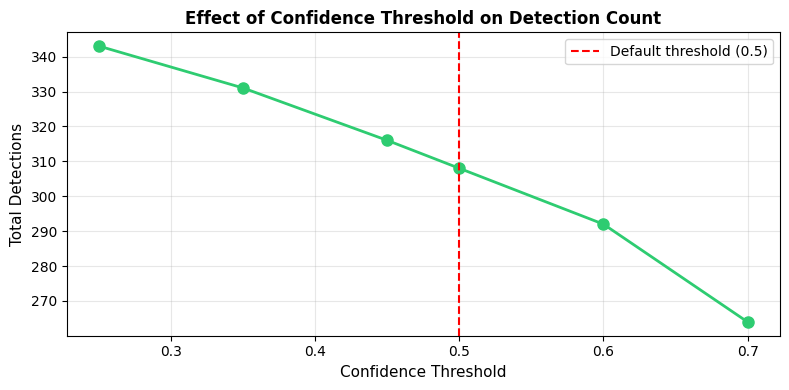

In [39]:
# Threshold sweep to analyze detection behavior
thresholds = [0.25, 0.35, 0.45, 0.50, 0.60, 0.70]
detection_counts = []

print(f"{'Threshold':<12} {'Total Detections':<20} {'Images w/ Detection':<22}")
print("-" * 55)

for thresh in thresholds:
    results_t = finetuned_model.predict(
        source=TEST_IMAGES_PATH,
        conf=thresh,
        verbose=False
    )
    total_d = sum(len(r.boxes) if r.boxes is not None else 0 for r in results_t)
    imgs_d = sum(1 for r in results_t if r.boxes is not None and len(r.boxes) > 0)
    detection_counts.append(total_d)
    print(f"{thresh:<12.2f} {total_d:<20} {imgs_d:<22}")

# Plot threshold vs detections
plt.figure(figsize=(8, 4))
plt.plot(thresholds, detection_counts, marker='o', color='#2ecc71', linewidth=2, markersize=8)
plt.axvline(x=0.5, color='red', linestyle='--', label='Default threshold (0.5)')
plt.xlabel('Confidence Threshold', fontsize=11)
plt.ylabel('Total Detections', fontsize=11)
plt.title('Effect of Confidence Threshold on Detection Count', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('/content/threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 8: Summary and Conclusions

This section summarizes findings from the experiment.

In [40]:
# Final summary printout
print("=" * 65)
print(" A3: SMALL OBJECT DETECTION — FINAL SUMMARY")
print("=" * 65)
print()
print("Dataset: LISA Traffic Sign Dataset (via Roboflow)")
print(f"Classes: {TARGET_CLASSES}")
print()
print("── Pre-trained Model (YOLOv8n, COCO weights) ──────────────")
print(f"  Cannot be evaluated with LISA class labels (different")
print(f"  class set). Used as qualitative baseline only.")
print(f"  Detections on test set: {total_detections}")
print()
print("── Fine-tuned Model (YOLOv8n, LISA weights) ───────────────")
print(f"  mAP@0.50:       {finetuned_metrics.box.map50:.4f}")
print(f"  mAP@0.50:0.95:  {finetuned_metrics.box.map:.4f}")
print(f"  Precision:      {finetuned_metrics.box.mp:.4f}")
print(f"  Recall:         {finetuned_metrics.box.mr:.4f}")
print(f"  Detections on test set: {ft_total_detections}")
print()
print("── Key Configurations for Small Object Detection ──────────")
print("  imgsz=1280   Higher resolution preserves small sign detail")
print("  augment=True Scale/blur/rotation augmentation")
print("  mosaic=1.0   Multi-scale object exposure")
print("  conf=0.50    Balanced precision-recall threshold")
print("=" * 65)

 A3: SMALL OBJECT DETECTION — FINAL SUMMARY

Dataset: LISA Traffic Sign Dataset (via Roboflow)
Classes: ['stopSign', 'warning', 'pedestrianCrossing', 'signalAhead']

── Pre-trained Model (YOLOv8n, COCO weights) ──────────────
  Cannot be evaluated with LISA class labels (different
  class set). Used as qualitative baseline only.
  Detections on test set: 2427

── Fine-tuned Model (YOLOv8n, LISA weights) ───────────────
  mAP@0.50:       0.4588
  mAP@0.50:0.95:  0.3340
  Precision:      0.4828
  Recall:         0.4241
  Detections on test set: 308

── Key Configurations for Small Object Detection ──────────
  imgsz=1280   Higher resolution preserves small sign detail
  augment=True Scale/blur/rotation augmentation
  mosaic=1.0   Multi-scale object exposure
  conf=0.50    Balanced precision-recall threshold


---

## References

1. Jocher, G. et al. (2023). *Ultralytics YOLOv8*. https://github.com/ultralytics/ultralytics  
2. Mogelmose, A., Trivedi, M. M., & Moeslund, T. B. (2012). *Vision-based Traffic Sign Detection and Analysis for Intelligent Driver Assistance Systems: Perspectives and Survey.* IEEE Transactions on Intelligent Transportation Systems.  
3. LISA Traffic Sign Dataset. Roboflow Universe. https://universe.roboflow.com/lisatrafficlight/lisa-traffic  
4. Redmon, J., & Farhadi, A. (2018). *YOLOv3: An Incremental Improvement.* arXiv:1804.02767.